In [1563]:
import torch
from torchvision import transforms, datasets
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [1564]:
df = pd.read_csv("train_data.csv")

# Data processing
- y - class from 0 to 3 according to the following:
    - 0 to 100k - class 0
    - 100k to 350k - class 1
    - 350k and above - class 2
        

Features:
- YearBuilt - numeric
- Size(sqf) - numeric
- Floor - numeric
- HallwayType - one hot encoding
- HeatingType - binary encoding
- AptManageType - binary encoding
- N_Parkinglot(Ground) - numeric
- N_Parkinglot(Basement) - numeric
- TimeToBusStop - one hot encoding
- TimeToSubway - one hot encoding
- N_manager - numeric
- N_elevators - numeric
- SubwayStation - one hot encoding
- N_FacilitiesInApt - numeric
- N_FacilitiesNearBy(Total) - numeric
- N_SchoolNearBy(Total) - numeric

Train data: 4124
Train data per class: 0 - 562, 1 - 2992, 2 - 570


In [1565]:
df

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [1566]:
def preprocess_data(df: pd.DataFrame, assign_classes=True) -> pd.DataFrame:

    if assign_classes:
        df['class'] = pd.cut(df['SalePrice'], bins=[-float('inf'), 100000, 350000, float('inf')], labels=[0, 1, 2])
        df = df.drop(columns=["SalePrice"])

    # Encode TimeToSubway and TimeToBus
    df['TimeToBusStop'] = df['TimeToBusStop'].replace({
        "0~5min": 2,
        "5min~10min": 1,
        "10min~15min": 0
    })

    df['TimeToSubway'] = df['TimeToSubway'].replace({
        "0-5min": 4,
        "5min~10min": 3,
        "10min~15min": 2,
        "15min~20min": 1,
        "no_bus_stop_nearby": 0

    })

    # House age encoding
    df['YearBuilt'] = (df['YearBuilt'].max() - df['YearBuilt']) / (df['YearBuilt'].max() - df['YearBuilt'].min())
    
    # One hot encoding
    for_one_hot_encoding = ['HallwayType', 'SubwayStation']
    drop_first = True
    
    df = pd.get_dummies(df, columns=for_one_hot_encoding, drop_first=drop_first)
    
    # Binary encoding
    for_binary = ['HeatingType', 'AptManageType']
    df = pd.get_dummies(df, columns=for_binary, drop_first=True)
    
    # Scale numeric to range 0 to 1
    to_be_scaled = ['TimeToBusStop', 'TimeToSubway', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
    for column in to_be_scaled:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    # Cluster
    features = df[['Size(sqf)', 'Floor', 'YearBuilt', 'N_FacilitiesNearBy(Total)']]
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['Cluster'] = kmeans.fit_predict(features) / 5

    # Cluster 2
    features = df[['N_FacilitiesInApt', 'N_Parkinglot(Basement)']]
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster2'] = kmeans.fit_predict(features) / 3
    
    return df

In [1567]:
df = preprocess_data(df)
df

/tmp/ipykernel_11272/2839157569.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToBusStop'] = df['TimeToBusStop'].replace({
/tmp/ipykernel_11272/2839157569.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToSubway'] = df['TimeToSubway'].replace({


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby,HeatingType_individual_heating,AptManageType_self_management,Cluster,Cluster2
0,0.243243,0.308356,0.047619,0.155680,0.139288,0.5,0.50,0.153846,0.000000,0.444444,...,False,False,True,False,False,False,True,False,0.0,0.333333
1,0.810811,0.205268,0.166667,0.112202,0.057532,1.0,0.75,0.076923,0.074074,0.222222,...,False,True,False,False,False,False,True,True,0.2,0.333333
2,0.810811,0.205268,0.119048,0.112202,0.057532,1.0,0.75,0.076923,0.074074,0.222222,...,False,True,False,False,False,False,True,True,0.2,0.333333
3,0.243243,0.872389,0.166667,0.349229,0.405753,1.0,1.00,0.307692,0.407407,0.444444,...,False,False,False,False,True,False,True,False,0.6,0.333333
4,0.621622,0.231153,0.023810,0.199158,0.059803,0.5,0.25,0.230769,0.296296,0.222222,...,False,False,False,True,False,False,True,True,0.2,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.216216,0.814260,0.547619,0.000000,0.961393,1.0,1.00,1.000000,0.592593,1.000000,...,False,False,True,False,False,False,True,False,0.6,0.000000
4120,0.000000,0.231153,0.500000,0.143058,0.302801,1.0,0.75,0.307692,0.370370,0.666667,...,False,True,False,False,False,False,True,False,0.6,0.666667
4121,0.216216,0.332879,0.452381,0.000000,0.961393,1.0,1.00,1.000000,0.592593,1.000000,...,False,False,True,False,False,False,True,False,0.6,0.000000
4122,1.000000,0.541326,0.000000,0.122020,0.000000,1.0,1.00,0.000000,0.148148,0.222222,...,False,False,True,False,False,False,True,True,0.2,0.333333


# Features correlation

In [1568]:
corr_matrix = df.corr()

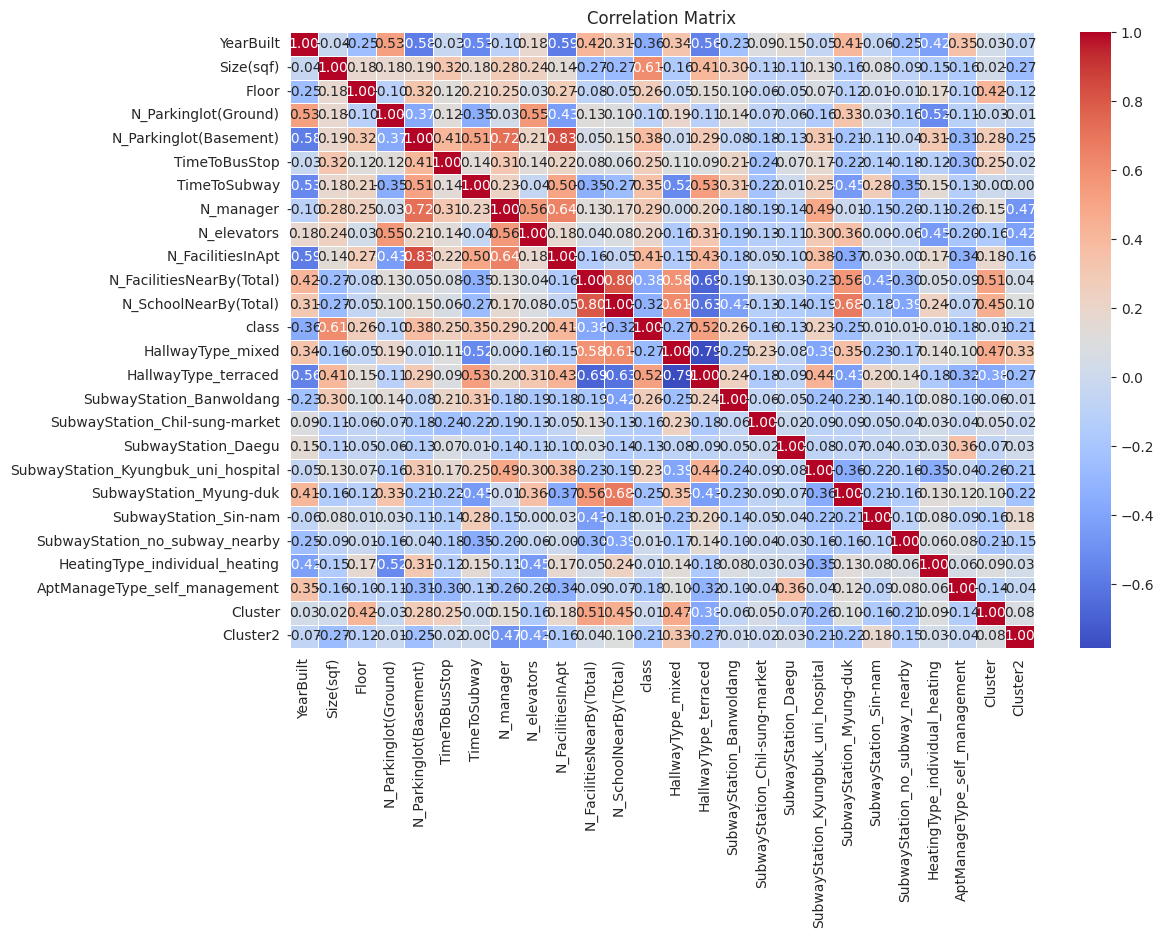

In [1569]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

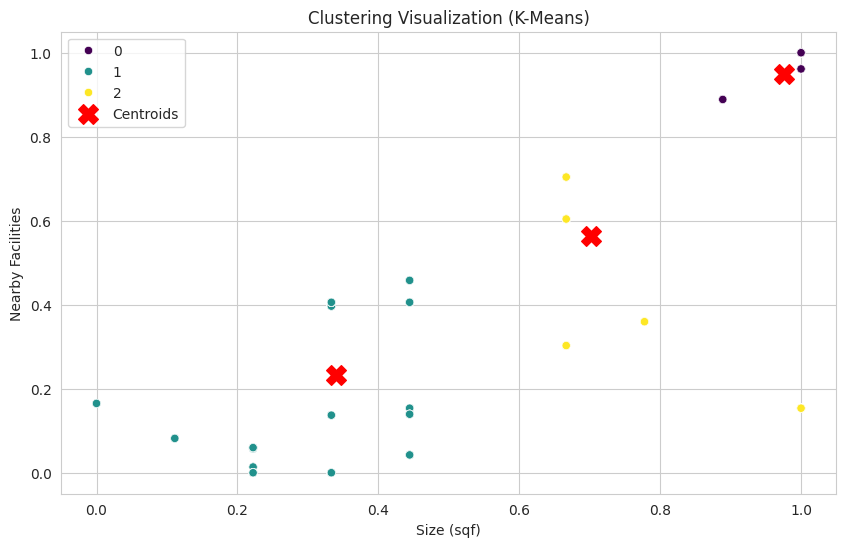

In [1570]:
from sklearn.cluster import KMeans

# Select two important features for visualization
X = df[['N_FacilitiesInApt', 'N_Parkinglot(Basement)']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['N_FacilitiesInApt'], y=df['N_Parkinglot(Basement)'], hue=df['Cluster'], palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title("Clustering Visualization (K-Means)")
plt.xlabel("Size (sqf)")
plt.ylabel("Nearby Facilities")
plt.legend()
plt.show()

In [1571]:
df.shape

(4124, 26)

In [1572]:
N_INPUTS = df.shape[1] - 1
N_OUTPUTS = 3

In [1573]:
class_counts = df['class'].to_numpy()
unique, counts = np.unique(class_counts, return_counts=True)

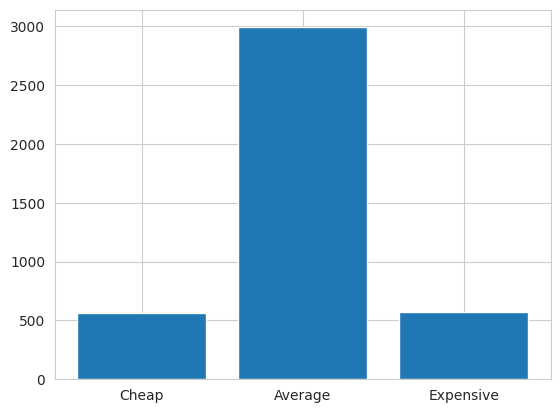

In [1574]:
plt.bar(["Cheap", "Average", "Expensive"], counts)
plt.show()

In [1575]:
class_weights = [1 / x for x in counts]
class_weights = [0.87, 0.76, 1.1]
print(class_weights)

[0.87, 0.76, 1.1]


In [1576]:
train_dataset_raw = df.sample(frac=0.8, random_state=200)
df = df.drop(train_dataset_raw.index)
val_dataset_raw = train_dataset_raw.sample(frac=0.125, random_state=200) # 20% of original dataset
train_dataset_raw = train_dataset_raw.drop(val_dataset_raw.index)

test_dataset_raw = df
print("Dataset sizes")
print(f"Train: {len(train_dataset_raw)} samples")
print(f"Val:   {len(val_dataset_raw)} samples")
print(f"Test:  {len(test_dataset_raw)} samples")

Dataset sizes
Train: 2887 samples
Val:   412 samples
Test:  825 samples


In [1577]:
train_labels = train_dataset_raw['class'].to_numpy().astype(np.int64)
train_data = train_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

val_labels = val_dataset_raw['class'].to_numpy().astype(np.int64)
val_data = val_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

test_labels = test_dataset_raw['class'].to_numpy().astype(np.int64)
test_data = test_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

In [1578]:
train_dataset = data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = data.TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))
test_dataset = data.TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

In [1579]:
sample_weights = np.array([class_weights[label] for label in train_labels])
sample_weights = torch.FloatTensor(sample_weights)

sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [1580]:
BATCH_SIZE = 512
train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_data_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [1581]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(device))
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

NVIDIA GeForce RTX 2070 Super
cuda


In [1582]:
class ApartmentClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.layer1 = nn.Linear(num_inputs, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.act_fn1 = nn.ReLU()
        self.d1 = nn.Dropout(0.25)

        self.layer2 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act_fn2 = nn.ReLU()
        self.d2 = nn.Dropout(0.25)

        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.act_fn3 = nn.ReLU()
        self.d3 = nn.Dropout(0.2)

        self.output = nn.Linear(128, num_outputs)


    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_fn1(x)
        x = self.d1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_fn2(x)
        x = self.d2(x)

        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act_fn3(x)
        x = self.d3(x)

        x = self.output(x)
        return x


In [1583]:
def predict_from_logits(logits, y_hat):
    pred_probabilites = nn.Softmax(dim=1)(logits)
    predictions = pred_probabilites.argmax(1)

    correct = (predictions == y_hat).sum().item()
    return predictions, correct

In [1584]:
def train(model: nn.Module, epochs: int, optimizer, scheduler) -> np.ndarray:
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []


    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        train_correct = 0
        train_total = 0

        val_correct = 0
        val_total = 0

        model.train()
        for data_inputs, data_labels in train_data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            logits = model(data_inputs)

            loss = loss_module(logits.squeeze(dim=1), data_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, correct = predict_from_logits(logits, data_labels)

            train_correct += correct
            train_total += data_labels.size(0)

        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = total_train_loss / len(train_data_loader)
        train_losses.append(avg_train_loss)
        train_acc.append(train_accuracy)


        model.eval()
        with torch.no_grad():
            for data_inputs, data_labels in val_data_loader:
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

                logits = model(data_inputs)


                loss = loss_module(logits.squeeze(dim=1), data_labels)
                total_val_loss += loss.item()

                _, correct = predict_from_logits(logits, data_labels)

                val_correct += correct
                val_total += data_labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = total_val_loss / len(val_data_loader)
        val_losses.append(avg_val_loss)
        val_acc.append(val_accuracy)

        scheduler.step()
        print(f"Epoch {epoch+1}| Train Loss = {avg_train_loss:.4f} Train acc = {train_accuracy:.4f}| Val Loss = {avg_val_loss:.4f}| Val acc = {val_accuracy:.4f}")

    history = [train_losses, train_acc, val_losses, val_acc]
    return np.array(history)

In [1585]:
model = ApartmentClassifier(N_INPUTS, N_OUTPUTS)
model.to(device)

ApartmentClassifier(
  (layer1): Linear(in_features=25, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn1): ReLU()
  (d1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=1024, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn2): ReLU()
  (d2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn3): ReLU()
  (d3): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [1586]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

class_weights = torch.FloatTensor(class_weights).cuda()
loss_module = nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


In [1587]:
history = train(model, epochs=200, optimizer=optimizer, scheduler=scheduler)

Epoch 1| Train Loss = 0.8070 Train acc = 62.2445| Val Loss = 1.0047| Val acc = 67.7184
Epoch 2| Train Loss = 0.5712 Train acc = 79.6675| Val Loss = 0.8470| Val acc = 73.5437
Epoch 3| Train Loss = 0.5060 Train acc = 81.0876| Val Loss = 0.6534| Val acc = 82.0388
Epoch 4| Train Loss = 0.4405 Train acc = 82.7503| Val Loss = 0.5469| Val acc = 81.0680
Epoch 5| Train Loss = 0.4333 Train acc = 82.8542| Val Loss = 0.4634| Val acc = 81.0680
Epoch 6| Train Loss = 0.4104 Train acc = 83.0966| Val Loss = 0.4444| Val acc = 80.8252
Epoch 7| Train Loss = 0.3915 Train acc = 83.8587| Val Loss = 0.4249| Val acc = 79.1262
Epoch 8| Train Loss = 0.3931 Train acc = 82.9234| Val Loss = 0.3920| Val acc = 82.5243
Epoch 9| Train Loss = 0.3963 Train acc = 82.5078| Val Loss = 0.4000| Val acc = 82.0388
Epoch 10| Train Loss = 0.3869 Train acc = 82.9234| Val Loss = 0.4088| Val acc = 78.6408
Epoch 11| Train Loss = 0.3756 Train acc = 82.7156| Val Loss = 0.4124| Val acc = 78.3981
Epoch 12| Train Loss = 0.3632 Train acc =

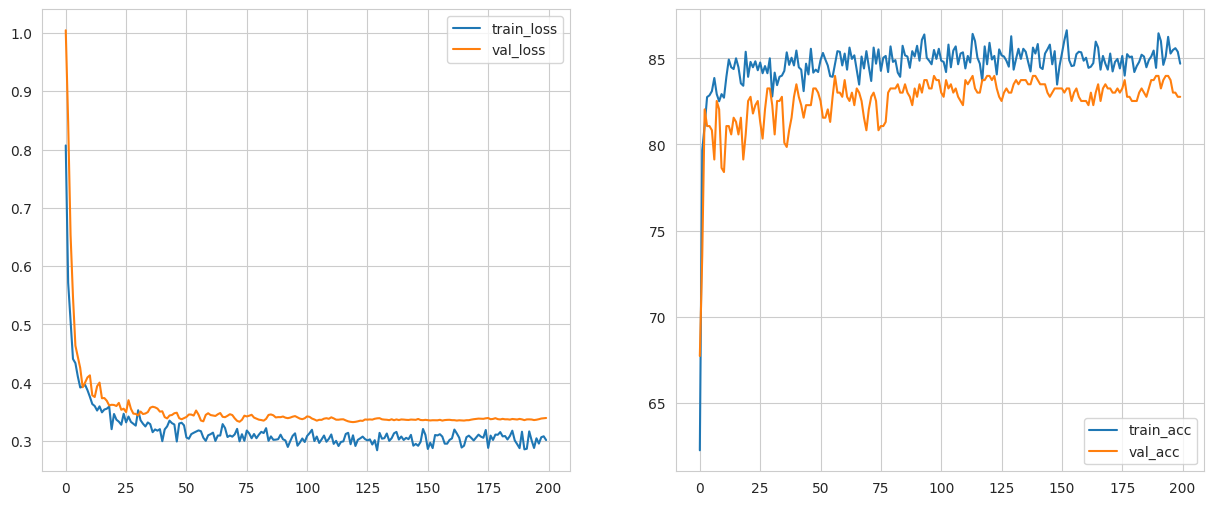

In [1588]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(history[0, :], label="train_loss")
ax1.plot(history[2, :], label="val_loss")
ax1.legend()

ax2.plot(history[1, :], label="train_acc")
ax2.plot(history[3, :], label="val_acc")
ax2.legend()

# Evaluation

In [1589]:
model.eval()
true_preds, num_preds = 0., 0.

test_y_hat = []
test_y = []
with torch.no_grad():
    for data_inputs, data_labels in test_data_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)


        logits = model(data_inputs)
        predictions, correct = predict_from_logits(logits, data_labels)


        test_y_hat.append(predictions.to("cpu").numpy())
        test_y.append(data_labels.to("cpu").numpy())

        true_preds += correct
        num_preds += data_labels.shape[0]

test_accuracy = (true_preds / num_preds) * 100.0
print(f"Accuracy of the model: {test_accuracy:.2f}%")

Accuracy of the model: 85.73%


In [1590]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [1591]:
test_y = np.concatenate(test_y)
test_y_hat = np.concatenate(test_y_hat)

In [1592]:
cm = confusion_matrix(test_y, test_y_hat)

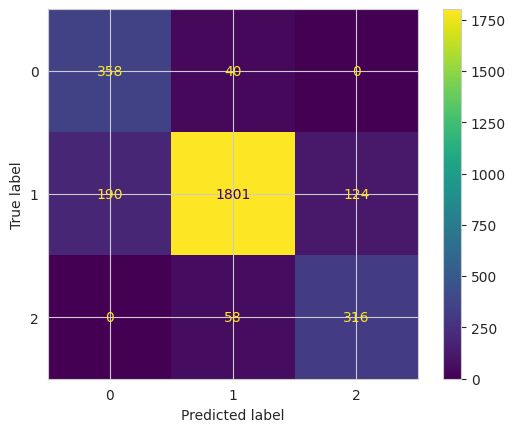

In [1593]:

disp = ConfusionMatrixDisplay(cm, display_labels=[str(x) for x in range(cm.shape[0])])
disp.plot()
plt.show()

In [1594]:
def accuracies_for_classes(cm: np.array):
    accuracies = []
    for class_idx in range(cm.shape[0]):
        acc = (cm[class_idx, class_idx] / np.sum(cm[class_idx, :])) * 100
        accuracies.append(acc)

    return accuracies

In [1595]:
accuracies = accuracies_for_classes(cm)
labels = ["Cheap", "Average", "Expensive"]
for i, acc in enumerate(accuracies):
    print(f"Accuracy for class {labels[i]:<10} ({i}): {acc:.2f} %")
print()
print(f"Test accuracy: {test_accuracy:.2f} %")

Accuracy for class Cheap      (0): 89.95 %
Accuracy for class Average    (1): 85.15 %
Accuracy for class Expensive  (2): 84.49 %

Test accuracy: 85.73 %


In [1596]:
state_dict = model.state_dict()
torch.save(state_dict, "apartments_model.tar")

# Generate predictions for test_data.csv

In [1597]:
df_test = pd.read_csv("test_data.csv")

In [1598]:
df_test = preprocess_data(df_test, assign_classes=False)

/tmp/ipykernel_11272/2839157569.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToBusStop'] = df['TimeToBusStop'].replace({
/tmp/ipykernel_11272/2839157569.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToSubway'] = df['TimeToSubway'].replace({


In [1599]:
state_dict = torch.load("apartments_model.tar")


model = ApartmentClassifier(N_INPUTS, N_OUTPUTS).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [1600]:
df_test = df_test.to_numpy().astype(np.float32)

In [1601]:
test_data = torch.from_numpy(df_test).float()

In [1602]:
model.eval()

with torch.no_grad():
    samples = test_data.to(device)
    logits = model(samples)

    pred_probabilites = nn.Softmax(dim=1)(logits)
    predictions = pred_probabilites.argmax(1)

    y_hat = predictions.to("cpu").numpy()

y_hat = y_hat.astype(np.int32)

In [1603]:
y_hat.dtype

dtype('int32')

In [1604]:
np.savetxt("pred.csv", y_hat, fmt="%d")